Kaggleのデータセットを用いるため,mydrive等にkaggle.jsonファイルを置いてください,

In [2]:
# Kaggle APIの設定
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json # kaggle.jsonのパスを正しく指定
!chmod 600 ~/.kaggle/kaggle.json

# Kaggleデータセットをダウンロード
!kaggle datasets download -d markdaniellampa/fish-dataset

# データセットの解凍
import zipfile

with zipfile.ZipFile('fish-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/fish_dataset')

# データ構造を確認
import os

for root, dirs, files in os.walk('/content/fish_dataset'):
    print(f'Root: {root}')
    print(f'Subdirectories: {dirs}')
    print(f'Files: {files[:5]}')  # 大量のファイルがある場合に備えて一部のみ表示
    print('-' * 40)


cp: missing destination file operand after '/content/drive/MyDrive/kaggle.json'
Try 'cp --help' for more information.
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/markdaniellampa/fish-dataset
License(s): Community Data License Agreement - Sharing - Version 1.0
fish-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Root: /content/fish_dataset
Subdirectories: ['FishImgDataset']
Files: []
----------------------------------------
Root: /content/fish_dataset/FishImgDataset
Subdirectories: ['train', 'test', 'val']
Files: []
----------------------------------------
Root: /content/fish_dataset/FishImgDataset/train
Subdirectories: ['Tenpounder', 'Indian Carp', 'Snakehead', 'Scat Fish', 'Mudfish', 'Freshwater Eel', 'Mosquito Fish', 'Pangasius', 'Catfish', 'Glass Perchlet', 'Silver Carp', 'Silver Perch', 'Tilapia', 'Silver Barb', 'Green Spotted Puffer', 'Climbing Perch', 'Grass

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# データジェネレータの設定
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    '/content/fish_dataset/FishImgDataset/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/fish_dataset/FishImgDataset/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# モデルの構築
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(31, activation='softmax') # クラス数を31に設定
])

# モデルのコンパイル
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# モデルのトレーニング
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=20
)

# モデルの保存
model.save('/content/fish_classification_model.keras') # 推奨される.keras形式で保存

# モデルをローカルにダウンロード
from google.colab import files
files.download('/content/fish_classification_model.keras')


Found 7047 images belonging to 31 classes.
Found 1744 images belonging to 31 classes.
Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 514s 2s/step - accuracy: 0.1525 - loss: 3.3126 - val_accuracy: 0.3027 - val_loss: 2.6648
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.2812 - loss: 2.5392 - val_accuracy: 0.1875 - val_loss: 2.8813
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 518s 2s/step - accuracy: 0.3508 - loss: 2.3443 - val_accuracy: 0.3895 - val_loss: 2.2116
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4375 - loss: 2.0053 - val_accuracy: 0.4375 - val_loss: 2.0553
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 559s 2s/step - accuracy: 0.5218 - loss: 1.6830 - val_accuracy: 0.4502 - val_loss: 2.0477
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4062 - loss: 1.9382 - val_accuracy: 0.2500 - val_loss: 2.2349
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 561s 2s/step - accuracy: 0.6718 - loss: 1.1313 - val_accuracy: 0.4954 - val_loss: 2.0296
Epoch 8/20


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# テストデータジェネレータの設定
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/fish_dataset/FishImgDataset/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False # 混同行列のためにシャッフルしない
)


Found 1760 images belonging to 31 classes.


In [9]:
# モデルのロード
model = tf.keras.models.load_model('/content/fish_classification_model.keras')

# テストデータでの評価
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // 32)
print(f'Test Accuracy: {test_accuracy:.2f}')
print(f'Test Loss: {test_loss:.2f}')


55/55 ━━━━━━━━━━━━━━━━━━━━ 49s 888ms/step - accuracy: 0.8192 - loss: 1.0379
Test Accuracy: 0.84
Test Loss: 0.93


55/55 ━━━━━━━━━━━━━━━━━━━━ 44s 795ms/step


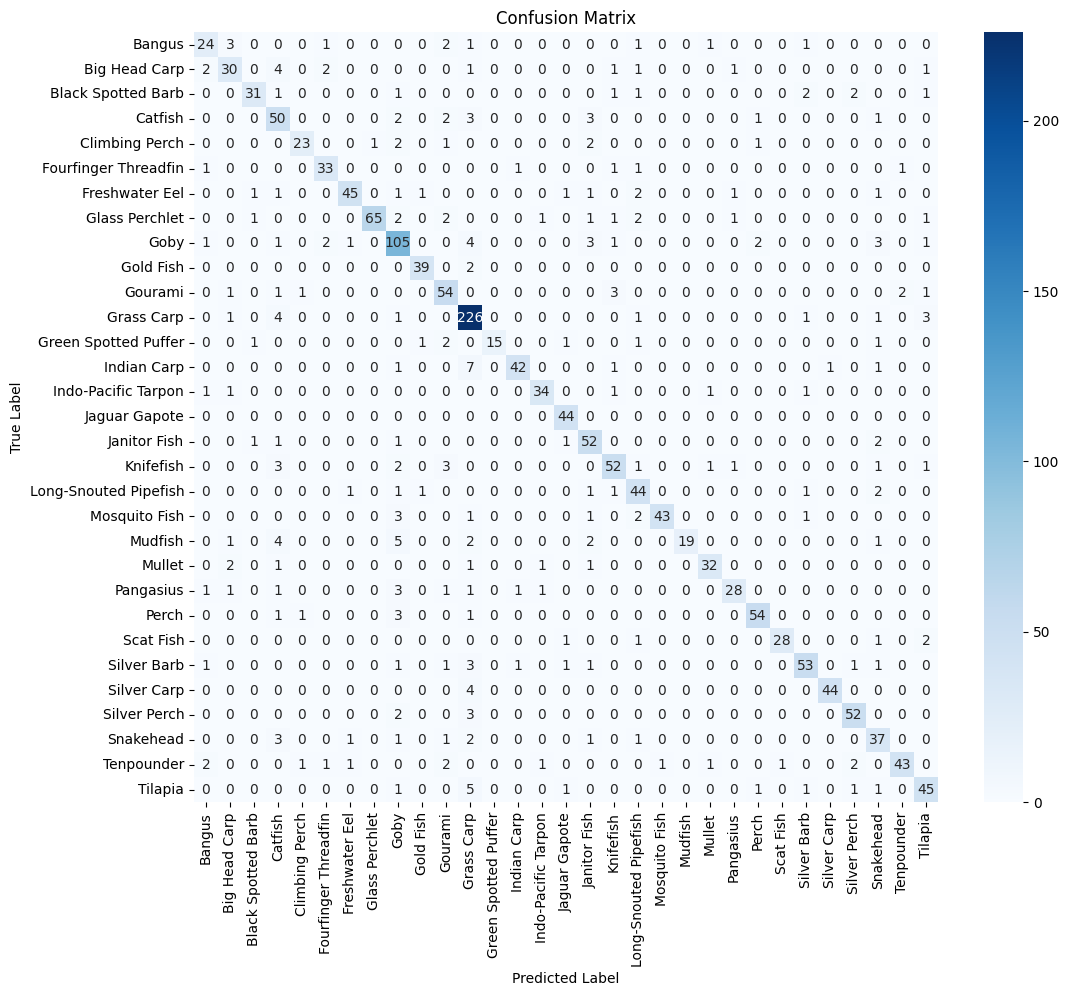

                       precision    recall  f1-score   support

               Bangus       0.73      0.71      0.72        34
        Big Head Carp       0.75      0.70      0.72        43
   Black Spotted Barb       0.89      0.78      0.83        40
              Catfish       0.66      0.81      0.72        62
       Climbing Perch       0.88      0.77      0.82        30
 Fourfinger Threadfin       0.85      0.87      0.86        38
       Freshwater Eel       0.92      0.82      0.87        55
       Glass Perchlet       0.98      0.84      0.91        77
                 Goby       0.76      0.85      0.80       124
            Gold Fish       0.93      0.95      0.94        41
              Gourami       0.76      0.86      0.81        63
           Grass Carp       0.85      0.95      0.90       238
 Green Spotted Puffer       1.00      0.68      0.81        22
          Indian Carp       0.93      0.79      0.86        53
  Indo-Pacific Tarpon       0.89      0.87      0.88  

In [10]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 予測の取得
Y_pred = model.predict(test_generator, steps=test_generator.samples // 32)
y_pred = np.argmax(Y_pred, axis=1)

# クラスラベルの取得
class_labels = list(test_generator.class_indices.keys())

# 混同行列の生成
conf_matrix = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# 分類レポートの表示
report = classification_report(test_generator.classes, y_pred, target_names=class_labels)
print(report)


In [7]:
# モデルをローカルにダウンロード
from google.colab import files
files.download('/content/fish_classification_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# 入力層を明示的に定義
input_shape = (150, 150, 3)
inputs = Input(shape=input_shape)

# MobileNetV2のベースモデルを使用
base_model = MobileNetV2(input_tensor=inputs, include_top=False, weights='imagenet')
base_model.trainable = False # 最初は事前学習済みの重みを固定

# 転移学習用の新しい分類層を追加
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(31, activation='softmax')(x)

# 新しいモデルの定義
model = Model(inputs=inputs, outputs=outputs)

# モデルのコンパイル
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 転移学習のトレーニング
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=10
)

# ファインチューニングの準備
base_model.trainable = True
fine_tune_at = 100 # 最初の100層は固定
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 再コンパイル（ファインチューニング用に学習率を小さく設定）
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ファインチューニングのトレーニング
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=10
)

# ファインチューニング後のモデルの保存
model.save('/content/fish_classification_model_finetuned.keras')
files.download('/content/fish_classification_model_finetuned.keras')


<ipython-input-13-5aca06059539>:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_tensor=inputs, include_top=False, weights='imagenet')


Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 222s 967ms/step - accuracy: 0.3665 - loss: 2.5131 - val_accuracy: 0.6580 - val_loss: 1.2201
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4375 - loss: 1.6211 - val_accuracy: 0.6875 - val_loss: 1.0275
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 262s 976ms/step - accuracy: 0.6590 - loss: 1.1508 - val_accuracy: 0.6794 - val_loss: 1.1003
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8125 - loss: 0.8395 - val_accuracy: 0.8125 - val_loss: 0.8281
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 209s 944ms/step - accuracy: 0.7529 - loss: 0.8416 - val_accuracy: 0.7350 - val_loss: 0.9970
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9375 - loss: 0.3374 - val_accuracy: 0.7500 - val_loss: 0.6983
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 216s 978ms/step - accuracy: 0.7836 - loss: 0.7089 - val_accuracy: 0.7413 - val_loss: 0.9332
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8750 - loss: 0.4493 - 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# TensorFlowと必要なライブラリのインポート
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# 保存したモデルのロード
model = tf.keras.models.load_model('/content/fish_classification_model_finetuned.keras')


In [15]:
# モデルのロード
model = tf.keras.models.load_model('/content/fish_classification_model_finetuned.keras')

# テストデータでの評価
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // 32)
print(f'Test Accuracy: {test_accuracy:.2f}')
print(f'Test Loss: {test_loss:.2f}')


55/55 ━━━━━━━━━━━━━━━━━━━━ 46s 789ms/step - accuracy: 0.8647 - loss: 0.5229
Test Accuracy: 0.89
Test Loss: 0.40
